In [73]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(12)


In [74]:
def lin2db(x):
    return 10*np.log10(x)

def db2lin(x):
    return 10**(x/10)

A variável $\Delta$ é referente ao espaço entre as antenas.

A variável $M$ é referente ao número de antenas

A variável $d$ se refere a chegada do sinal

O tempo de chegada do sinal em cada antena é definido por:

$\tau_M(\theta_i) = (M-1)\frac{\Delta \sin{\theta_i}}{c}$

As frequencias espaciais são:

$\mu_i = - \frac{2\pi f_c}{c}\Delta \sin(\theta_i) \therefore \mu_i = -\pi \sin(\theta_i)$ se $\Delta = \frac{\lambda}{2}$



A matriz tem formato $M\times d$

In [75]:
# Definindo os parametros a serem utilizados

c_velocity = 3e8
frequency = 2.4e9 # 2.4 GHz
wavelength = c_velocity / frequency
delta = wavelength / 2 # Espaço entre cada antena

m_antennas = 8 # Número de antenas
d_chegada = 2 # Distância de chegada
theta_i = [30, 60] # Ângulos de chegada
theta_i = np.radians(theta_i)
t_snapshot = 100 # Número de snapshots
snr = 0 # dB

In [76]:
# Fazendo os cálculos necessários
mu_spatial_frequency = -np.pi*np.sin(theta_i)

A_ula = np.zeros((m_antennas, d_chegada), dtype=complex)
#A_ula_mod = np.zeros((m_antennas, d_chegada))
#A_ula_phase = np.zeros((m_antennas, d_chegada))

for col in range (d_chegada):
    for row in range (m_antennas):
        A_ula[row, col] = np.exp(1j * row * mu_spatial_frequency[col])
        #A_ula_mod[row, col] = np.abs(A_ula[row, col])
        #A_ula_phase[row, col] = np.angle(A_ula[row, col])

print(A_ula)

[[ 1.00000000e+00+0.00000000e+00j  1.00000000e+00+0.00000000e+00j]
 [ 2.83276945e-16-1.00000000e+00j -9.12724198e-01-4.08576233e-01j]
 [-1.00000000e+00-5.66553890e-16j  6.66130924e-01+7.45834829e-01j]
 [-1.07187544e-15+1.00000000e+00j -3.03263428e-01-9.52906760e-01j]
 [ 1.00000000e+00+1.13310778e-15j -1.12539185e-01+9.93647287e-01j]
 [ 1.19434012e-15-1.00000000e+00j  5.08697903e-01-8.60945087e-01j]
 [-1.00000000e+00-2.14375088e-15j -8.16062586e-01+5.77963541e-01j]
 [-2.20498322e-15+1.00000000e+00j  9.80982236e-01-1.94097532e-01j]]


In [77]:

rank = np.linalg.matrix_rank(A_ula)
print(f'O rank da matriz A é {rank}')

O rank da matriz A é 2


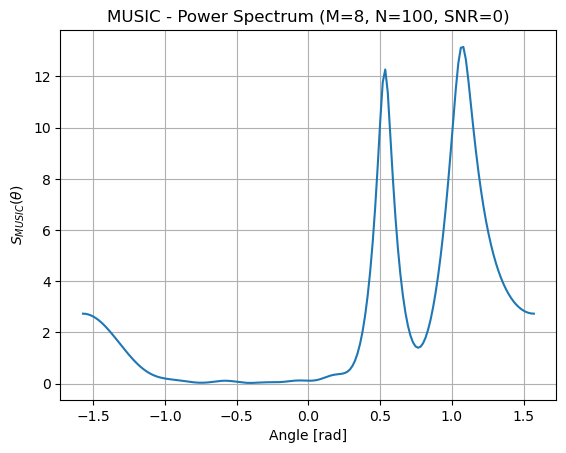

In [78]:
# Fazendo o algoritmo de MUSIC

sinal = np.zeros((d_chegada, t_snapshot), dtype=complex)

# Definindo o sinal que é transmitido e deixando-o no formato d x t, como uma senoide
for i in range(d_chegada):
    sinal[i] = np.sin(2*np.pi*random.random()*np.arange(t_snapshot))


sinal_aula = np.dot(A_ula, sinal) # Multiplicando a matriz A pela matriz sinal

# Adicionando ruído ao sinal, fazendo do ruído um ruído branco gaussiano com desvio padrão 1
noise = np.random.normal(0, 1, (m_antennas, t_snapshot)) + 1j*np.random.normal(0, 1, (m_antennas, t_snapshot))
sinal_final = sinal_aula + noise

# Calculando a matriz de covariância
sinal_final_hermetiano = np.conj(sinal_final.T)
covariance_matrix_estimada = np.dot(sinal_final, sinal_final_hermetiano) / t_snapshot

# Obtendo os autovalores e autovetores da matriz de covariância
eigenvalues, eigenvec = np.linalg.eig(covariance_matrix_estimada)

# Ordenando os autovalores em ordem decrescente
eigenvalues_decres = eigenvalues.argsort()[::-1]

# Deixando os autovetores na ordem dos autovalores para que assim eles fiquem alinhados
eigenvec = eigenvec[:, eigenvalues_decres]

# Definindo o subespaço de ruído
noise_subspace = eigenvec[:, d_chegada:]

# Estimando o espectro de potência
angles = np.linspace(-np.pi/2, np.pi/2, 180)
p_spectrum = np.zeros(angles.shape)

# Calculando o espectro de potência
for index_angle, angle in enumerate(angles):
    steering_vector = np.exp(1j * np.arange(m_antennas) * (-np.pi * np.sin(angle))) # Vetor de direção, que é o vetor de entrada da matriz A

    numerator = np.abs(np.dot(np.conj(steering_vector.T), steering_vector))
    denominator = np.abs(np.dot(np.conj(steering_vector.T), np.dot(noise_subspace, np.dot(np.conj(noise_subspace.T), steering_vector))))
    
    p_spectrum[index_angle] = numerator / denominator if denominator != 0 else 0

# Plotando o espectro de potência
plt.plot(angles, lin2db(p_spectrum))
plt.xlabel('Angle [rad]')
plt.ylabel('$S_{MUSIC}(\\theta)$')
plt.title('MUSIC - Power Spectrum (M=8, N=100, SNR=0)')
plt.grid()
plt.show()


Até agora trabalhamos com a SNR = $0$, no entanto, iremos agora plotar para SNR = $ \{-5, 0, 5, 10, 15, 20\}$

A mudança de SNR está relacionada ao desvio padrão do ruído, já que a potência de transmissão sempre será a mesma, logo, para mudar a SNR, temos que:

$P_{\text{noise}} = \frac{P_{t}}{SNR},$

Considerando que iremos transformar as SNR de dB para linear e sabendo que modelamos o ruído como $P_t \sim \mathcal{N}(0, \sigma^2)$, logo:

$\sigma = \sqrt{\frac{P_t}{SNR}},\; P_t = 1 \therefore \sigma = \sqrt{SNR^{-1}}$

Fazendo agora a mudança para os diferentes valores de SNR



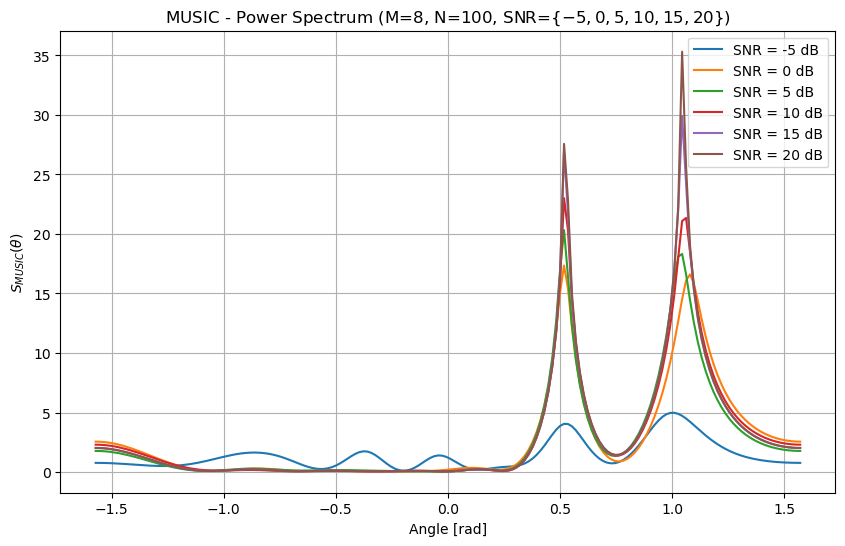

In [79]:
snr_values = np.arange(-5, 21, 5) # Valores de SNR em dB

plt.figure(figsize=(10,6))
for snr in snr_values:
    snr_lin = db2lin(snr)
    standard_deviation = 1 / np.sqrt(snr_lin)

    # Adicionando ruído ao sinal, fazendo do ruído um ruído branco gaussiano com desvio padrão 
    noise = np.random.normal(0, standard_deviation, (m_antennas, t_snapshot)) + 1j*np.random.normal(0, standard_deviation, (m_antennas, t_snapshot))

    sinal_final = sinal_aula + noise
    # Calculando a matriz de covariância
    sinal_final_hermetiano = np.conj(sinal_final.T)
    covariance_matrix_estimada = np.dot(sinal_final, sinal_final_hermetiano) / t_snapshot

    # Obtendo os autovalores e autovetores da matriz de covariância
    eigenvalues, eigenvec = np.linalg.eig(covariance_matrix_estimada)

    # Ordenando os autovalores em ordem decrescente
    eigenvalues_decres = eigenvalues.argsort()[::-1]

    # Deixando os autovetores na ordem dos autovalores para que assim eles fiquem alinhados
    eigenvec = eigenvec[:, eigenvalues_decres]

    # Definindo o subespaço de ruído
    noise_subspace = eigenvec[:, d_chegada:]

    # Estimando o espectro de potência
    angles = np.linspace(-np.pi/2, np.pi/2, 180)
    p_spectrum = np.zeros(angles.shape)

    # Calculando o espectro de potência
    for index_angle, angle in enumerate(angles):
        steering_vector = np.exp(1j * np.arange(m_antennas) * (-np.pi * np.sin(angle))) # Vetor de direção, que é o vetor de entrada da matriz A

        numerator = np.abs(np.dot(np.conj(steering_vector.T), steering_vector))
        denominator = np.abs(np.dot(np.conj(steering_vector.T), np.dot(noise_subspace, np.dot(np.conj(noise_subspace.T), steering_vector))))
        
        p_spectrum[index_angle] = numerator / denominator if denominator != 0 else 0     

    plt.plot(angles, lin2db(p_spectrum), label=f'SNR = {snr} dB')

plt.xlabel('Angle [rad]')
plt.ylabel('$S_{MUSIC}(\\theta)$')
plt.title('MUSIC - Power Spectrum (M=8, N=100, SNR=$\{-5, 0, 5, 10, 15, 20\}$)')
plt.grid()
plt.legend()
plt.savefig('music.pdf')
plt.show()